In [65]:
import pyfesom2 as pf
import xarray as xr
import os
import pandas as pd
from collections import OrderedDict
from itertools import product
import matplotlib.pylab as plt
import numpy as np
from matplotlib import cm
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import tqdm as tqdm
from cdo import *   # python version
cdo = Cdo()
import csv
import cmocean as cmo
import dask
from dask.delayed import delayed
from dask.diagnostics import ProgressBar
import math


In [255]:
# parameters cell
meshpath = '/p/project/chhb19/streffing1/input/fesom2/core2/'
remap_resolution = '360x180'
mesh_file = 'CORE2_finaltopo_mean.nc'
abg = [0, 0, 0]
variable = 'MLD2'
#input_paths = ["/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/PICT/outdata/fesom/","/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/fesom/"
#               ]
#input_names = ['PICT','HIST']
input_paths = ["/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/PICT/outdata/fesom/"
               ]
input_names = ['PICT']
years = range(1990, 2014)

figsize=(6,4.5)
levels = [0, 3000, 11]
units = r'$^\circ$C'
columns = 2
dpi = 300
ofile = variable
region = "Global Ocean"

In [256]:
# Obtain input names from path if not set explicitly
if input_names is None:
    input_names = []
    for run in input_paths:
        run = os.path.join(run, '')
        input_names.append(run.split('/')[-2])

In [257]:
# Load fesom2 mesh
mesh = pf.load_mesh(meshpath, abg=abg, 
                    usepickle=True, usejoblib=False)

/p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /p/project/chhb19/streffing1/input/fesom2/core2/pickle_mesh_py3_fesom2


In [258]:
# Set number of columns, in case of multiple variables
def define_rowscol(input_paths, columns=len(input_paths), reduce=0):
    number_paths = len(input_paths) - reduce
#     columns = columns
    if number_paths < columns:
        ncol = number_paths
    else:
        ncol = columns
    nrows = math.ceil(number_paths / columns)
    return [nrows, ncol]

In [259]:
# Load model Data
data = OrderedDict()

def load_parallel(variable,path,remap_resolution,meshpath,mesh_file):
    data1 = cdo.yearmean(input='-setmissval,nan -setctomiss,0 -remap,r'+remap_resolution+','+meshpath+'/weights_unstr_2_r'+remap_resolution+'.nc -setgrid,'+meshpath+'/'+mesh_file+' '+str(path),returnArray=variable)
    return data1


for exp_path, exp_name  in zip(input_paths, input_names):

    datat = []
    t = []
    temporary = []
    for year in tqdm.tqdm(years):
        path = exp_path+'/'+variable+'.fesom.'+str(year)+'.nc'
        temporary = dask.delayed(load_parallel)(variable,path,remap_resolution,meshpath,mesh_file)
        t.append(temporary)

    with ProgressBar():
        datat = dask.compute(t)
    data[exp_name] = np.squeeze(datat)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 17064.47it/s]

[                                        ] | 0% Completed |  0.1s

[########################################] | 100% Completed |  3.8s


In [260]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

/tmp/ipykernel_6986/3541346302.py:8: RuntimeWarning: Mean of empty slice
  data_model_mean[exp_name] = np.nanmean(data_model_mean[exp_name],axis=0)


(180, 360)


/tmp/ipykernel_6986/3541346302.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30)
convert: unable to open image 'MLD2': No such file or directory @ error/blob.c/OpenBlob/3533.
convert: no decode delegate for this image format `' @ error/constitute.c/ReadImage/572.
convert: no images defined `MLD2_trimmed.png' @ error/convert.c/ConvertImageCommand/3322.
mv: cannot stat 'MLD2_trimmed.png': No such file or directory


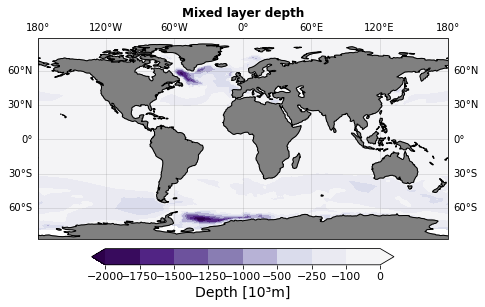

In [264]:
data_model_mean = OrderedDict()

levels = [-2000., -1750., -1500.,  -1250.,  -1000., -500,  -250., -100.,0]

for exp_name in input_names:
    data_model_mean[exp_name] = data[exp_name]
    if len(np.shape(data_model_mean[exp_name])) > 2:
        data_model_mean[exp_name] = np.nanmean(data_model_mean[exp_name],axis=0)

print(np.shape(data_model_mean[exp_name]))

lon = np.arange(0, 360, 1)
lat = np.arange(-90, 90, 1)
data_model_mean[exp_name], lon = add_cyclic_point(data_model_mean[exp_name], coord=lon)


nrows, ncol = define_rowscol(input_paths)
fig, axes = plt.subplots(nrows=nrows, ncols=ncol, figsize=figsize)
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]
i = 0


    
for key in input_names:

    axes[i]=plt.subplot(nrows,ncol,i+1,projection=ccrs.PlateCarree())
    axes[i].add_feature(cfeature.COASTLINE,zorder=3)

    new_cmap = truncate_colormap(plt.cm.PuOr_r, 0, 0.5)
    
    imf=plt.contourf(lon, lat, data_model_mean[exp_name], cmap=new_cmap, 
                     levels=levels, extend='both',
                     transform=ccrs.PlateCarree(),zorder=1)

    axes[i].set_ylabel('K')
    axes[i].set_xlabel('Simulation Year')
    axes[i].set_title("Mixed layer depth",fontweight="bold")
    axes[i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='grey'))

    plt.tight_layout() 
    
    gl = axes[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='-')
    gl.xlabels_bottom = False
    
    cbar_ax_abs = fig.add_axes([0.15, 0.11, 0.7, 0.05])
    cbar_ax_abs.tick_params(labelsize=12)
    cb = fig.colorbar(imf, cax=cbar_ax_abs, orientation='horizontal',ticks=levels)
    cb.set_label(label="Depth [10³m]", size='14')
    cb.ax.tick_params(labelsize='11')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30)

    
    i = i+1

    
#for label in cb.ax.xaxis.get_ticklabels()[::2]:
#    label.set_visible(False)

    
ofile=variable
    
if ofile is not None:
    plt.savefig(ofile, dpi=dpi,bbox_inches='tight')
    os.system(f'convert {ofile} -trim {ofile}_trimmed.png')
    os.system(f'mv {ofile}_trimmed.png {ofile}')